In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

## ConvNet

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3641)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

Helper function to quickly normalize with the mean and standard deviation from our training set:

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

Let's check it behaved properly.

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
x_valid.mean(),x_valid.std()

(tensor(-0.0058), tensor(0.9924))

In [8]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

To refactor layers, it's useful to have a `Lambda` layer that can take a basic function and convert it to a layer you can put in `nn.Sequential`.

NB: if you use a Lambda layer with a lambda function, your model won't pickle so you won't be able to save it with PyTorch. So it's best to give a name to the function you're using inside your Lambda (like flatten below).

In [9]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:

In [10]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

We can now define a simple CNN.

In [11]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [12]:
model = get_cnn_model(data)

Basic callbacks from the previous notebook:

In [13]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [14]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [15]:
%time run.fit(1, learn)

train: [2.1787971875, tensor(0.2160)]
valid: [2.0075658203125, tensor(0.3387)]
CPU times: user 7.49 s, sys: 806 ms, total: 8.29 s
Wall time: 3.78 s


## CUDA

This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3799)

In [16]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [17]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [18]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [19]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [20]:
cbfs.append(CudaCallback)

In [21]:
model = get_cnn_model(data)

In [22]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [23]:
%time run.fit(3, learn)

train: [2.06373796875, tensor(0.2725, device='cuda:0')]
valid: [1.50159375, tensor(0.5450, device='cuda:0')]
train: [0.53649109375, tensor(0.8300, device='cuda:0')]
valid: [0.214484423828125, tensor(0.9379, device='cuda:0')]
train: [0.1832394921875, tensor(0.9432, device='cuda:0')]
valid: [0.12799578857421876, tensor(0.9625, device='cuda:0')]
CPU times: user 5.42 s, sys: 517 ms, total: 5.93 s
Wall time: 3.4 s


Now, that's definitely faster!

## Refactor model

First we can regroup all the conv/relu in a single function:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3961)

In [24]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

Another thing is that we can do the mnist resize in a batch transform, that we can do with a Callback.

In [25]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [26]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

With the `AdaptiveAvgPool`, this model can now work on any size input:

In [27]:
nfs = [8,16,32,32]

In [28]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

And this helper function will quickly give us everything needed to run the training.

In [29]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [30]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [31]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [32]:
run.fit(3, learn)

train: [2.18057546875, tensor(0.2085, device='cuda:0')]
valid: [1.61200078125, tensor(0.4312, device='cuda:0')]
train: [0.65462453125, tensor(0.7968, device='cuda:0')]
valid: [0.2799553466796875, tensor(0.9144, device='cuda:0')]
train: [0.2257726953125, tensor(0.9330, device='cuda:0')]
valid: [0.15941590576171874, tensor(0.9526, device='cuda:0')]


## Hooks

### Manual insertion

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4353)

In [44]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [45]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [46]:
run.fit(2, learn)

train: [2.28108734375, tensor(0.1646, device='cuda:0')]
valid: [2.1727333984375, tensor(0.3028, device='cuda:0')]
train: [2.28952125, tensor(0.1737, device='cuda:0')]
valid: [2.3003509765625, tensor(0.1099, device='cuda:0')]


Now we can have a look at the means and stds of the activations at the beginning of training.

In [47]:
len(model.act_means)

7

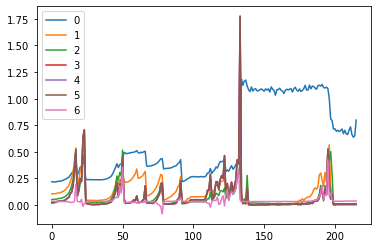

In [48]:
for l in model.act_means: plt.plot(l)
plt.legend(range(len(model.act_means)));

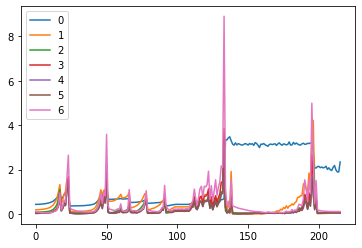

In [49]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(len(model.act_means)));

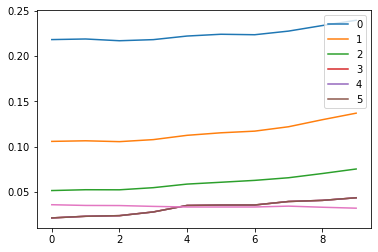

In [50]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

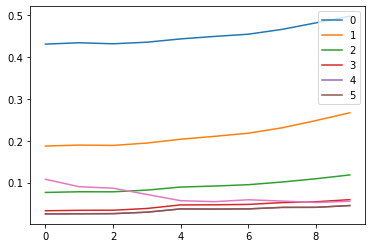

In [51]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4693)

In [108]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [109]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]
act_mins  = [[] for _ in model]
act_maxs  = [[] for _ in model]
act_medians  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [110]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())
    act_mins[i].append(outp.data.min())
    act_maxs[i].append(outp.data.max())
    act_medians[i].append(outp.data.median())

In [111]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [112]:
run.fit(1, learn)

train: [2.00008109375, tensor(0.3004, device='cuda:0')]
valid: [0.84789697265625, tensor(0.7075, device='cuda:0')]


In [113]:
print(len(act_means))
print(len(act_means[0]))
print(len(act_stds[6]))
print(len(act_medians[6]))

7
108
108
108


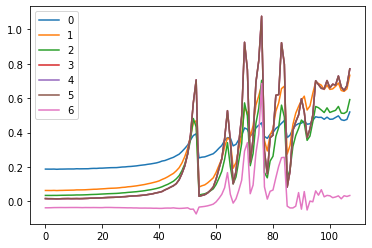

In [114]:
for o in act_means: plt.plot(o)
plt.legend(range(7));

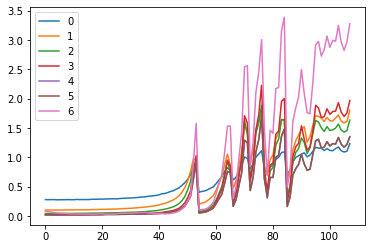

In [115]:
for o in act_stds: plt.plot(o)
plt.legend(range(7));

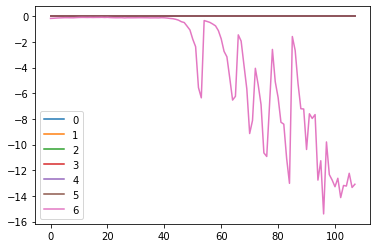

In [116]:
for o in act_mins: plt.plot(o)
plt.legend(range(7));

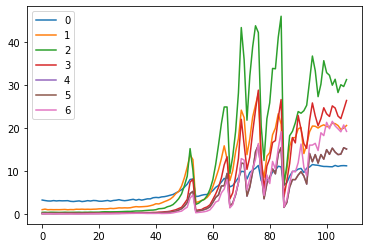

In [117]:
for o in act_maxs: plt.plot(o)
plt.legend(range(7));

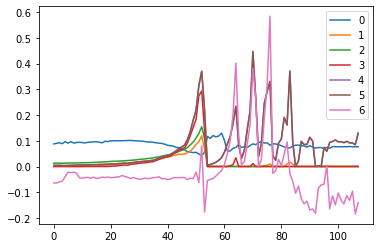

In [118]:
for o in act_medians: plt.plot(o)
plt.legend(range(7));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4836)

In [124]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

NB: In fastai we use a `bool` param to choose whether to make it a forward or backward hook. In the above version we're only supporting forward hooks.

In [125]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [126]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [127]:
run.fit(1, learn)

train: [1.92488828125, tensor(0.3389, device='cuda:0')]
valid: [1.33649072265625, tensor(0.5726, device='cuda:0')]


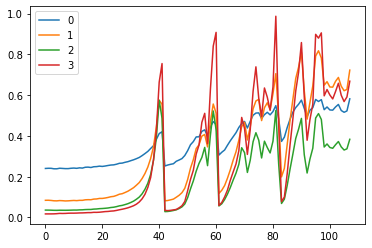

In [128]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

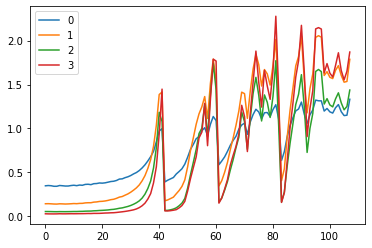

In [129]:
for h in hooks:
    plt.plot(h.stats[1])
    h.remove()
plt.legend(range(4));

### A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

The `__iter__` method is there to be able to do things like `for x in ...`.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=4972)

In [130]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [131]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [132]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [133]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a `Hooks` class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [143]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [144]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [145]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fe0e4d14f90>, <__main__.Hook object at 0x7fe0e4d19d10>, <__main__.Hook object at 0x7fe0e4d91810>, <__main__.Hook object at 0x7fe0e4d91e10>, <__main__.Hook object at 0x7fe0e4d91850>, <__main__.Hook object at 0x7fe0e4d91790>, <__main__.Hook object at 0x7fe0e4d91ad0>]

In [146]:
hooks.remove()

In [147]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [148]:
x.mean(),x.std()

(tensor(-0.0113, device='cuda:0'), tensor(0.9882, device='cuda:0'))

In [149]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1807, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3438, device='cuda:0', grad_fn=<StdBackward0>))

In [150]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [151]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4800, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9147, device='cuda:0', grad_fn=<StdBackward0>))

Having given an `__enter__` and `__exit__` method to our `Hooks` class, we can use it as a context manager. This makes sure that onces we are out of the `with` block, all the hooks have been removed and aren't there to pollute our memory.

train: [2.08351953125, tensor(0.2697, device='cuda:0')]
valid: [1.4424240234375, tensor(0.4920, device='cuda:0')]
train: [0.49936078125, tensor(0.8461, device='cuda:0')]
valid: [0.23498955078125, tensor(0.9301, device='cuda:0')]


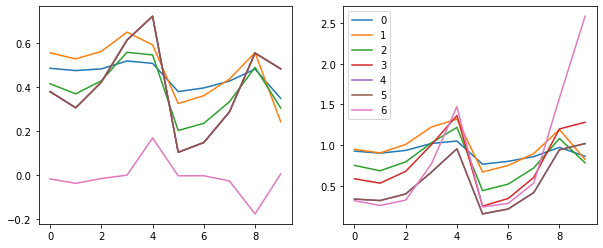

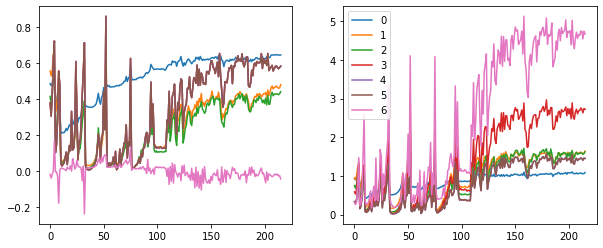

In [152]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(7));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(7));

### Other statistics

Let's store more than the means and stds and plot histograms of our activations now.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5233)

In [153]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [154]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [155]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [156]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [2.34962609375, tensor(0.1398, device='cuda:0')]
valid: [2.302290625, tensor(0.1064, device='cuda:0')]


In [157]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5582)

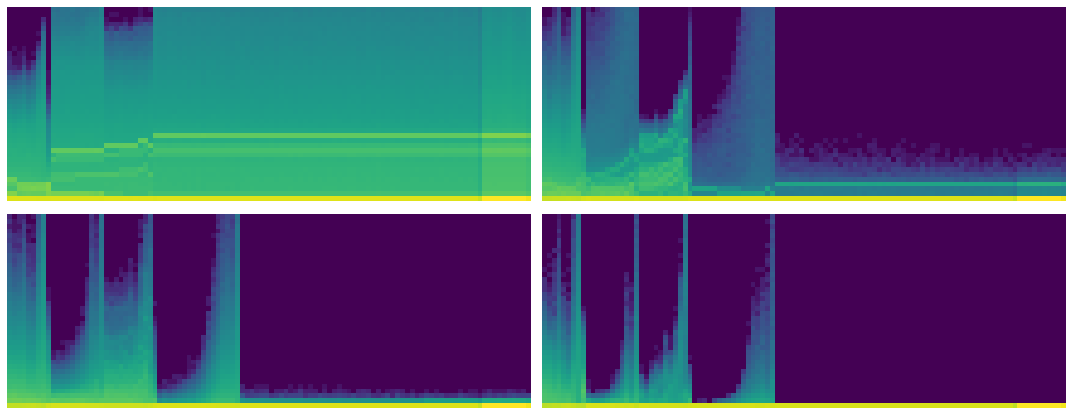

In [158]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

From the histograms, we can easily get more informations like the min or max of the activations

In [159]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

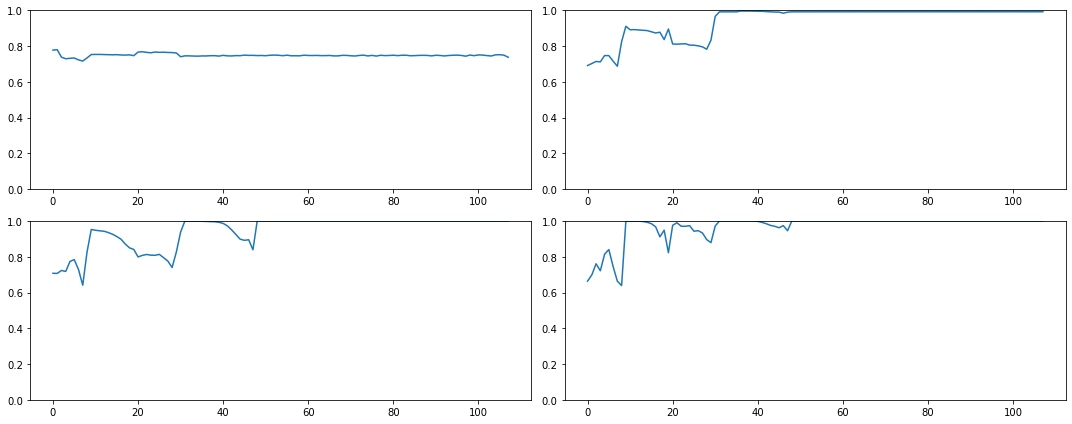

In [160]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

## Generalized ReLU

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5390)

In [165]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [166]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [167]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.52104734375, tensor(0.8335, device='cuda:0')]
valid: [0.1558115234375, tensor(0.9533, device='cuda:0')]


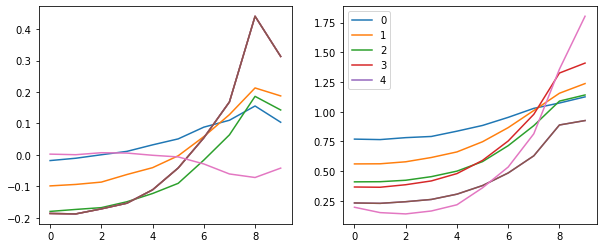

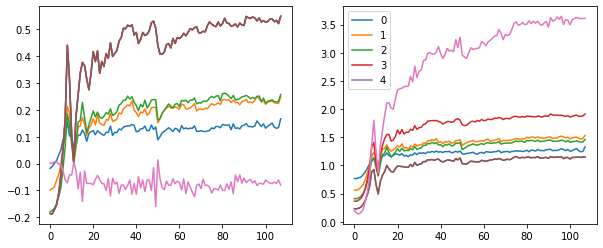

In [168]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

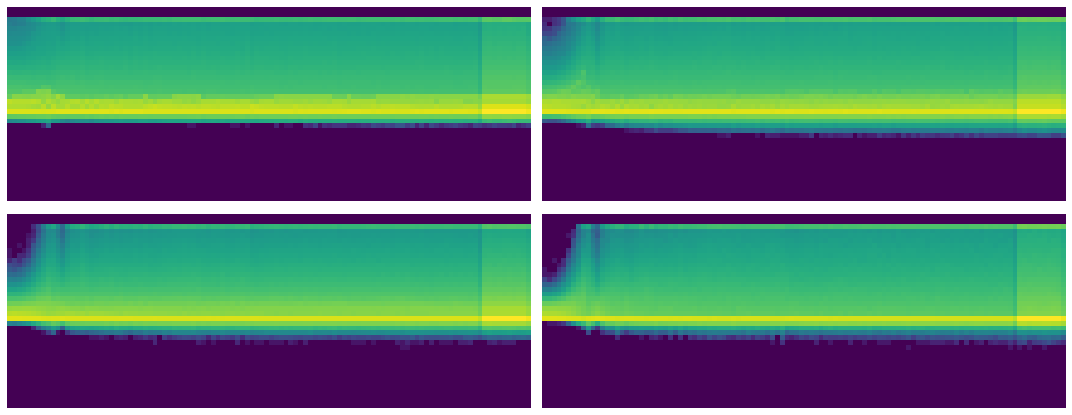

In [169]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [170]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

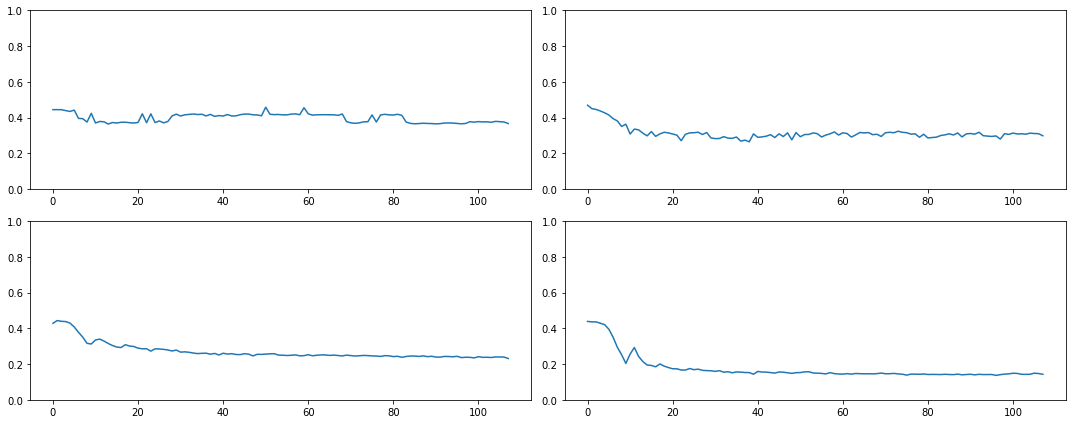

In [171]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5705)

In [172]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [173]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [174]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [175]:
run.fit(8, learn)

train: [1.0339065625, tensor(0.6821, device='cuda:0')]
valid: [0.26896962890625, tensor(0.9187, device='cuda:0')]
train: [0.272469765625, tensor(0.9169, device='cuda:0')]
valid: [1.0366447265625, tensor(0.6779, device='cuda:0')]
train: [0.24142671875, tensor(0.9266, device='cuda:0')]
valid: [0.1334888671875, tensor(0.9583, device='cuda:0')]
train: [0.668653125, tensor(0.8118, device='cuda:0')]
valid: [1.5464705078125, tensor(0.4818, device='cuda:0')]
train: [0.618618515625, tensor(0.8227, device='cuda:0')]
valid: [0.2068302734375, tensor(0.9397, device='cuda:0')]
train: [0.17390271484375, tensor(0.9477, device='cuda:0')]
valid: [0.1292513671875, tensor(0.9623, device='cuda:0')]
train: [0.11696998046875, tensor(0.9635, device='cuda:0')]
valid: [0.11005059814453125, tensor(0.9687, device='cuda:0')]
train: [0.097437353515625, tensor(0.9701, device='cuda:0')]
valid: [0.10357198486328124, tensor(0.9699, device='cuda:0')]


Uniform init may provide more useful initial weights (normal distribution puts a lot of them at 0).

In [176]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [177]:
run.fit(8, learn)

train: [1.112765234375, tensor(0.6612, device='cuda:0')]
valid: [0.2514550537109375, tensor(0.9284, device='cuda:0')]
train: [0.499156171875, tensor(0.8515, device='cuda:0')]
valid: [0.23763076171875, tensor(0.9311, device='cuda:0')]
train: [0.237451875, tensor(0.9279, device='cuda:0')]
valid: [0.14630240478515624, tensor(0.9568, device='cuda:0')]
train: [0.10784103515625, tensor(0.9674, device='cuda:0')]
valid: [0.08562109985351563, tensor(0.9742, device='cuda:0')]
train: [0.0756858837890625, tensor(0.9767, device='cuda:0')]
valid: [0.06675614013671875, tensor(0.9804, device='cuda:0')]
train: [0.0546552587890625, tensor(0.9835, device='cuda:0')]
valid: [0.05741043090820312, tensor(0.9835, device='cuda:0')]
train: [0.0405480078125, tensor(0.9877, device='cuda:0')]
valid: [0.0549487548828125, tensor(0.9843, device='cuda:0')]
train: [0.03345038330078125, tensor(0.9904, device='cuda:0')]
valid: [0.05306591796875, tensor(0.9843, device='cuda:0')]


## Export

Here's a handy way to export our module without needing to update the file name - after we define this, we can just use `nb_auto_export()` in the future (h/t Stas Bekman):

In [ ]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()

<IPython.core.display.Javascript object>